In [1]:
%matplotlib inline
from IPython.display import display
from itertools import chain
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
import scipy as sc
from sklearn import preprocessing
from collections import Counter
from utils import *

import seaborn as sns
sns.set(style="white", color_codes=True)



import math
from geopy.geocoders import Nominatim
from mpl_toolkits.basemap import Basemap

/Users/hongjian/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def getFreq(df, col = 'StoreID', name = 'count'):
    freq = Counter(df[col])
    df1 = pd.DataFrame(list(freq.keys()), columns=[col])
    df2 = pd.DataFrame(list(freq.values()), columns=[name])
    freq_df = pd.concat([df1, df2], axis=1)
    return freq_df

In [3]:
df = pd.read_csv('../data/exist_town_state.csv')
df.columns = ['StoreID', 'Town', 'State']

#State_store_count
freq_df = getFreq(df, 'State', 'State_store_count')
df = pd.merge(df, freq_df, how='left', on='State')

# remove town index
df['Town'] = df.Town.str.split(' ',1).str[1]
# freq_df = getFreq(df, 'Town', 'Town_store_count')
# df = pd.merge(df, freq_df, how='left', on='Town')

train = pd.read_csv('../data/train.csv', usecols=['Agencia_ID'])
train.columns = ['StoreID']
freq_df = getFreq(train, col = 'StoreID', name = 'sell_item_counts')
df = pd.merge(df, freq_df, how='left', on='StoreID')

df_town = df[['State','Town']]
df_town = df_town.drop_duplicates()

In [13]:
def reformat_town(town, state):
    new_town = town.replace('.', '. ').replace('_', ' ')\
                    .replace('TLAQUEPARQUE', 'TLAQUEPAQUE')\
                    .replace('Cruce De Anden', ' ')\
                    .replace('Cruce De Andén', ' ')\
                    .split()
    # remove last digit
    if new_town[-1].isdigit():
        new_town = new_town[:-1]
    new_town = ' '.join([x for x in new_town if x not in {'AG', 'BM', 'BIMBO', 'BLM', 'BI', 
                                                          'WONDER','MLA', 'MM', 
                                                          'BW', 'MARINELA', 'AUTOSERVICIOS', 
                                                          'AUTOSERVICI', 'AUTOSERVICIO'
                                                         } and '.' not in x])
    new_town_list = new_town.split()
    new_town2 = ' '.join( new_town_list[1:] + [new_town_list[0]]) 
    new_town3 = new_town_list[0]
    new_towns = [town + ','+ state, new_town + ','+ state, new_town , new_town2, new_town3+ ','+ state]
    return new_towns
        
    


def getSpatialFeatures(df_town):
    geolocator = Nominatim()
    towns = list(df_town['Town'])
    states = list(df_town['State'])
    print len(towns)
    locs = []
    i = 0
    j = 0
    for town, state in zip(towns, states):
        if i < 0:
            i += 1
            continue
        print i
        i += 1
        
        new_towns = reformat_town(town, state)
       
        for new_town in new_towns:
            
            loc = geolocator.geocode(str(new_town)+', Mexico')
            if loc is not None:

                if 'Mexi'  in loc.raw['display_name']:
                    locs.append(loc.raw)
                    j += 1
                    break
        else:
            loc = geolocator.geocode(str(state)+', Mexico')
            locs.append(loc.raw)
            print i, '|', town, '|', state,  '|', new_town

    df_loc = pd.DataFrame(locs)
    return df_loc

df_loc = getSpatialFeatures(df_town)

257
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114 | Cruce De Anden Noroeste | BAJA CALIFORNIA NORTE | Noroeste,BAJA CALIFORNIA NORTE
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254

In [30]:
# print len(df_loc)
# geolocator = Nominatim()
# loc = geolocator.geocode('Noroeste , BAJA CALIFORNIA NORTE ,  México')
# print loc.raw

df_town = df_town.reset_index(drop=True)
df2 = pd.concat([df_town, df_loc], axis=1)
df2 = df2.drop(['boundingbox', 'icon', 'licence', 'osm_id', 'place_id', 'State'], axis = 1) #
df_res = pd.merge(df, df2, how='left', on='Town') #

freq_df = getFreq(df_res, 'lat', 'Town_store_count')
df_res = pd.merge(df_res, freq_df, how='left', on='lat')

df_res.to_csv('xx.csv', index = False, encoding='utf-8')

In [19]:
df2

,State,Town,boundingbox,class,display_name,icon,importance,lat,licence,lon,osm_id,osm_type,place_id,type
0,"MÉXICO, D.F.",AG. LAGO FILT,"[19.4407943, 19.4420677, -99.1958487, -99.1958...",highway,"Lago Filt, Chapultepec, Miguel Hidalgo, CDMX, ...",NaN,0.500000,19.4414357,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.1958255,25038978,way,63315399,residential
1,"MÉXICO, D.F.",AG. AZCAPOTZALCO,"[19.3651476, 19.3662509, -99.1999156, -99.1998...",highway,"Azcapotzalco, Campestre, Álvaro Obregón, CDMX,...",NaN,0.300000,19.3651476,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.1999156,183084924,way,102636221,residential
2,ESTADO DE MÉXICO,AG. CUAUTITLAN,"[19.6434112, 19.7666212, -99.200112, -99.1180221]",boundary,"Cuautitlán, México, Estados Unidos Mexicanos",https://nominatim.openstreetmap.org/images/map...,0.550000,19.70551825,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.166625587744,5605726,relation,145023922,administrative
3,"MÉXICO, D.F.",AG.IZTAPALAPA 2,"[19.302051, 19.382051, -99.0933064, -99.0133064]",place,"Iztapalapa, Estado de México, Estados Unidos M...",https://nominatim.openstreetmap.org/images/map...,0.500000,19.342051,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.0533064,3256536097,node,44649883,town
4,"MÉXICO, D.F.",AG. SAN ANTONIO,"[19.3172071, 19.3177722, -99.1496746, -99.1480...",highway,"San Antonio, Coyoacán, CDMX, 04600, Estados Un...",NaN,0.400000,19.3174105,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.1486261,337602473,way,133811747,residential
5,ESTADO DE MÉXICO,AG. ATIZAPAN,"[19.1622375, 19.1878256, -99.5194099, -99.4754...",boundary,"Atizapán, México, Estados Unidos Mexicanos",https://nominatim.openstreetmap.org/images/map...,0.550000,19.1749033,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.4978503618956,5605549,relation,143992747,administrative
6,"MÉXICO, D.F.",AG. LA VILLA,"[19.2854081, 19.2867081, -99.1188023, -99.1183...",highway,"Manifesto de Villa, Xochimilco, CDMX, 14378, E...",NaN,0.500000,19.2854081,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.1188023,52929354,way,72540004,residential
7,ESTADO DE MÉXICO,AG. MEGA NAUCALPAN,"[19.4806808, 19.4824429, -99.2497312, -99.2481...",shop,"MEGA, Via Adolfo Lopez Mateos, Naucalpan de Ju...",NaN,0.411000,19.4815668,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.2489577256932,412873918,way,2612476576,mall
8,"MÉXICO, D.F.",AG. TEPALCATES 2,"[19.38628, 19.39628, -99.051231, -99.041231]",railway,"Tepalcates, Calzada Ignacio Zaragoza, Iztapala...",https://nominatim.openstreetmap.org/images/map...,0.201000,19.39128,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.046231,1155521764,node,11884491,station
9,"MÉXICO, D.F.",AG. SAN LORENZO,"[19.3284307, 19.3295278, -99.1514288, -99.1507...",highway,"San Lorenzo, Taxqueña, Coyoacán, CDMX, 04330, ...",NaN,0.400000,19.3295278,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.1514288,162155989,way,96377759,residential


In [7]:
df_res

,State,Town,class,display_name,importance,lat,lon,osm_type,type
0,"MÉXICO, D.F.",AG. LAGO FILT,highway,"Lago Filt, Chapultepec, Miguel Hidalgo, CDMX, ...",0.500000,19.4414357,-99.1958255,way,residential
1,"MÉXICO, D.F.",AG. AZCAPOTZALCO,highway,"Azcapotzalco, Campestre, Álvaro Obregón, CDMX,...",0.300000,19.3651476,-99.1999156,way,residential
2,ESTADO DE MÉXICO,AG. CUAUTITLAN,boundary,"Cuautitlán, México, Estados Unidos Mexicanos",0.550000,19.70551825,-99.166625587744,relation,administrative
3,NaN,NaN,place,"Iztapalapa, Estado de México, Estados Unidos M...",0.500000,19.342051,-99.0533064,node,town
4,"MÉXICO, D.F.",AG.IZTAPALAPA 2,highway,"San Antonio, Coyoacán, CDMX, 04600, Estados Un...",0.400000,19.3174105,-99.1486261,way,residential
5,"MÉXICO, D.F.",AG. SAN ANTONIO,boundary,"Atizapán, México, Estados Unidos Mexicanos",0.550000,19.1749033,-99.4978503618956,relation,administrative
6,ESTADO DE MÉXICO,AG. ATIZAPAN,highway,"Manifesto de Villa, Xochimilco, CDMX, 14378, E...",0.500000,19.2854081,-99.1188023,way,residential
7,"MÉXICO, D.F.",AG. LA VILLA,shop,"MEGA, Via Adolfo Lopez Mateos, Naucalpan de Ju...",0.411000,19.4815668,-99.2489577256932,way,mall
8,ESTADO DE MÉXICO,AG. MEGA NAUCALPAN,railway,"Tepalcates, Calzada Ignacio Zaragoza, Iztapala...",0.201000,19.39128,-99.046231,node,station
9,"MÉXICO, D.F.",AG. TEPALCATES 2,highway,"San Lorenzo, Taxqueña, Coyoacán, CDMX, 04330, ...",0.400000,19.3295278,-99.1514288,way,residential


In [52]:
def prepareResults(df_res, df_loc):
    df_res = pd.concat([df_res, df_loc], axis=1)
    #scale the column to the range from 8 to 88
    df_res['count'] -= df_res['count'].min()
    df_res['count'] /= df_res['count'].max()
    df_res['count'] = df_res['count']*80+8
    df_res['count'] = df_res['count'].astype(int)
    #drop rows with no location information
    df_res = df_res.dropna()
    #lat and lon to float format
    df_res['lat'] = df_res['lat'].astype(float)
    df_res['lon'] = df_res['lon'].astype(float)
    return df_res
df_res = prepareResults(df_res, df_loc)
df_res

,Agencia_ID,count,Town,State,boundingbox,class,display_name,icon,importance,lat,licence,lon,osm_id,osm_type,place_id,type
0,2054,32,2174 SAN MIGUEL DE ALLENDE,GUANAJUATO,"[20.8883248, 20.934945, -100.7730585, -100.713...",place,"San Miguel de Allende, Guanajuato, Estados Uni...",https://nominatim.openstreetmap.org/images/map...,0.810085,20.913902,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-100.744012,2372616,relation,145025966,town
4,2060,42,2301 CUBILETE,GUANAJUATO,"[25.4601923, 25.5001923, -108.5401202, -108.50...",place,"El Cubilete, Guasave, Sinaloa, Estados Unidos ...",https://nominatim.openstreetmap.org/images/map...,0.375000,25.480192,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-108.520120,3750670156,node,48690503,village
5,2061,12,2175 TOLUCA AEROPUERTO,ESTADO DE MÉXICO,"[-33.5767415, -33.5467415, -70.7058026, -70.67...",aeroway,"Base Aérea El Bosque (SCBQ), Desvio Ochagavia,...",https://nominatim.openstreetmap.org/images/map...,0.001000,-33.561741,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-70.690803,625115216,node,5898127,aerodrome
10,2072,29,2186 LAGOS DE MORENO,JALISCO,"[21.3150172, 21.3950172, -101.9704644, -101.89...",place,"Lagos de Moreno, Jalisco, 47400, Estados Unido...",https://nominatim.openstreetmap.org/images/map...,0.647828,21.355017,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-101.930464,296372203,node,944636,town
12,2074,10,2044 CUERNAVACA BUENAVISTA,MORELOS,"[18.437778, 18.477778, -99.4319439, -99.3919439]",place,"Buenavista de Cuéllar, Guerrero, Estados Unido...",https://nominatim.openstreetmap.org/images/map...,0.375000,18.457778,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-99.411944,849912890,node,7372773,village
21,2092,8,2186 LAGOS DE MORENO,JALISCO,"[21.3150172, 21.3950172, -101.9704644, -101.89...",place,"Lagos de Moreno, Jalisco, 47400, Estados Unido...",https://nominatim.openstreetmap.org/images/map...,0.647828,21.355017,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-101.930464,296372203,node,944636,town
22,2095,9,2175 TOLUCA AEROPUERTO,ESTADO DE MÉXICO,"[-33.5767415, -33.5467415, -70.7058026, -70.67...",aeroway,"Base Aérea El Bosque (SCBQ), Desvio Ochagavia,...",https://nominatim.openstreetmap.org/images/map...,0.001000,-33.561741,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-70.690803,625115216,node,5898127,aerodrome
23,2096,8,2301 CUBILETE,GUANAJUATO,"[25.4601923, 25.5001923, -108.5401202, -108.50...",place,"El Cubilete, Guasave, Sinaloa, Estados Unidos ...",https://nominatim.openstreetmap.org/images/map...,0.375000,25.480192,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-108.520120,3750670156,node,48690503,village
30,2215,31,2392 MERIDA NORTE,YUCATÁN,"[47.2227704, 47.2627704, -100.9493071, -100.90...",place,"Merida, McLean County, North Dakota, United St...",https://nominatim.openstreetmap.org/images/map...,0.375000,47.242770,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-100.929307,151617193,node,375754,hamlet
34,2220,24,2395 PLAYA DEL CARMEN,QUINTANA ROO,"[20.4682229, 20.7882229, -87.2356577, -86.9156...",place,"Playa del Carmen, Solidaridad, Quintana Roo, E...",https://nominatim.openstreetmap.org/images/map...,0.663258,20.628223,"Data © OpenStreetMap contributors, ODbL 1.0. h...",-87.075658,279948657,node,832397,city


83


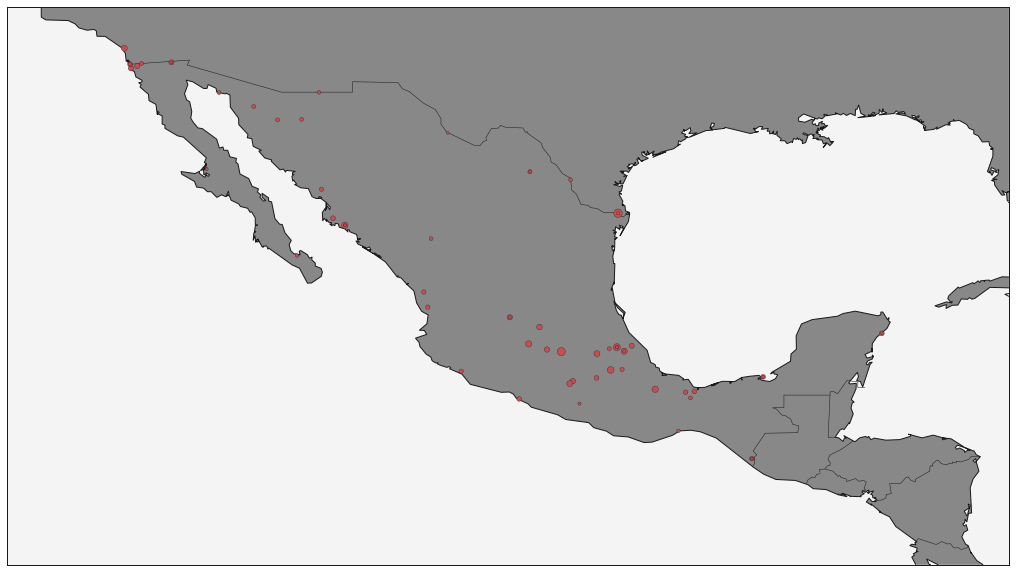

In [71]:
#http://introtopython.org/visualization_earthquakes.html

def drawMap(df):
   #from http://chrisalbon.com/python/matplotlib_plot_points_on_map.html
   fig = plt.figure(figsize=(20,10))
   m = Basemap(projection='gall', 
              # with low resolution,
              resolution = 'l', 
              # And threshold 100000
              area_thresh = 100000.0,
              llcrnrlon=-122, llcrnrlat=10.0,
              urcrnrlon= -82.0, urcrnrlat=35.0,
              # Centered at 0,0 (i.e null island)
              lat_0=23.0, lon_0=-102)

   # Draw the coastlines on the map
   m.drawcoastlines()
   # Draw country borders on the map
   m.drawcountries()
   # Fill the land with grey
   m.fillcontinents(color = '#888888')
   # Draw the map boundaries
   m.drawmapboundary(fill_color='#f4f4f4')
   x,y = m(df['lon'].values, df['lat'].values)
   z = df['count'].values
   print len(z)
   # Plot them using round markers of size 6
   #m.plot(x, y, 'ro', markersize=3)
   m.scatter(x, y, s=z, c='r', marker='o', zorder=2)
   # Show the map
   plt.show()
drawMap(df_res)

some error mapping the locations